# Module 03

## Session 06 Model Performance, Evaluation Method and Hyperparameter Tuning

# Algorithm Chains 2

* data: adult.csv
* target: income (>5k or <=50k)

preprocess:
1. missing value: simple imputer with constant
2. one hot encoding: relationship, race, sex
3. binary encoding: workcalss, marital status, occupation, native country
4. ordinal encoding: education (already encoded)
5. no treatment: numerical
6. out: fnlwgt

model:
1. random state = 10
2. data splitting 70:30
3. model tree(max depth 5, criterion entropy) and compute f1 score using cv
4. compute another metrics in another model too
5. model logistic regression (solver liblinear) compute recall, precision, f1, make ROC and PRC in test set
6. do hyperparameter tuning for logistic regression (optimize C and solver) optimized by f1 and using stratified CV 5 fold
7. compare the result, before and after, in test set

# Library

In [54]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, plot_roc_curve, plot_precision_recall_curve

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df_adult = pd.read_csv('datasets/adult.csv')

In [3]:
df_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# EDA

In [10]:
df_adult.replace('?', np.nan, inplace=True)

In [11]:
df_adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

# Preprocessing

In [12]:
onehot = OneHotEncoder(drop='first')
onehot_var = ['relationship', 'race', 'sex']

imputer = SimpleImputer(strategy='constant', fill_value='Others')
binary = ce.BinaryEncoder()

binary_pipe = Pipeline(
    [
        ('imputer', imputer),
        ('binary', binary)
    ]
)
binary_var = ['workclass', 'marital.status', 'occupation', 'native.country']

transformer = ColumnTransformer(
    [
        ('onehot', onehot, onehot_var),
        ('binary', binary_pipe, binary_var)
    ], remainder='passthrough'
)

# Data Splitting

In [29]:
X = df_adult.drop(columns=['income', 'fnlwgt', 'education'])
y = np.where(df_adult['income'] == '>50K', 1, 0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=10,
)

# Modeling (Benchmark)

In [32]:
skf = StratifiedKFold(n_splits=5)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=10)

estimator = Pipeline(
    [
        ('transformer', transformer),
        ('model', tree)
    ]
)

In [44]:
tree_cv = cross_val_score(estimator, X_train, y_train, scoring='f1')

In [34]:
tree_cv

array([0.6135094 , 0.61717172, 0.61113899, 0.61748358, 0.62020202])

In [35]:
tree_cv.mean()

0.6159011394046097

In [36]:
tree_cv.std()

0.003194200777543969

In [37]:
print('cross val result: ', tree_cv)
print('mean cross val result: ', tree_cv.mean())
print('std cross val result: ', tree_cv.std())

cross val result:  [0.6135094  0.61717172 0.61113899 0.61748358 0.62020202]
mean cross val result:  0.6159011394046097
std cross val result:  0.003194200777543969


# Another Model and Metrics

In [39]:
def model_evaluation_cv(model, metrics):
    skf = StratifiedKFold(n_splits=5)
    
    estimator = Pipeline(
        [
            ('transformer', transformer),
            ('model', model)
        ]
    )

    model_cv = cross_val_score(estimator, X_train, y_train, scoring=metrics)

    print('cross val result: ', model_cv)
    print('mean cross val result: ', model_cv.mean())
    print('std cross val result: ', model_cv.std())

In [47]:
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)

In [48]:
model_evaluation_cv(logreg, 'f1')

cross val result:  [0.64237776 0.65246212 0.63801337 0.63454198 0.66884633]
mean cross val result:  0.6472483134886825
std cross val result:  0.012362164275377705


In [45]:
model_evaluation_cv(knn, 'f1')

cross val result:  [0.65723131 0.6600346  0.65443425 0.667259   0.68693009]
mean cross val result:  0.6651778507211802
std cross val result:  0.011683462929397925


In [49]:
model_evaluation_cv(logreg, 'recall')

cross val result:  [0.56972789 0.58588435 0.56802721 0.56547619 0.60832625]
mean cross val result:  0.5794883798889139
std cross val result:  0.016096573580802676


# Benchmark Logistic Regression

In [50]:
logreg = LogisticRegression(solver='liblinear')

estimator = Pipeline(
    [
        ('transformer', transformer),
        ('model', logreg)
    ]
)

In [51]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['workclass',
                                                   'marital.st

In [53]:
y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6181
           1       0.75      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



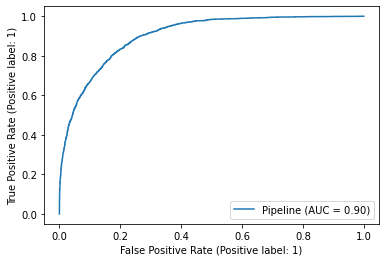

In [55]:
plot_roc_curve(estimator, X_test, y_test)

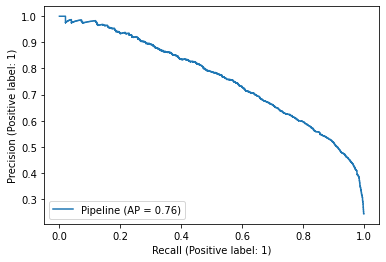

In [56]:
plot_precision_recall_curve(estimator, X_test, y_test)

# Hyperparameter Tuning

In [59]:
logreg = LogisticRegression(solver='liblinear', C=1)

estimator = Pipeline(
    [
        ('transformer', transformer),
        ('model', logreg)
    ]
)

hyperparam_space = {
    'model__C':[1000,100,10,1,0.1,0.01,0.001],
    'model__solver':['liblinear', 'newton-cg']
}

skf = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

In [60]:
grid_search.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='Others',
                                  

In [61]:
print('score: ', grid_search.best_score_)
print('model: ', grid_search.best_params_)

score:  0.6518301336287953
model:  {'model__C': 100, 'model__solver': 'newton-cg'}


In [62]:
cv_result = pd.DataFrame(grid_search.cv_results_)

In [63]:
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.352687,0.059685,0.034448,0.008793,1000,liblinear,"{'model__C': 1000, 'model__solver': 'liblinear'}",0.636015,0.650786,0.637972,0.634193,0.664158,0.644625,0.011373,10
1,6.006636,0.585791,0.035663,0.008676,1000,newton-cg,"{'model__C': 1000, 'model__solver': 'newton-cg'}",0.648034,0.657210,0.641545,0.641671,0.670386,0.651769,0.010924,2
2,0.456145,0.039472,0.037530,0.009458,100,liblinear,"{'model__C': 100, 'model__solver': 'liblinear'}",0.641798,0.648880,0.638663,0.634193,0.681924,0.649092,0.017099,6
3,5.171437,0.614301,0.038303,0.013639,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.648034,0.657210,0.641545,0.641975,0.670386,0.651830,0.010868,1
4,0.427624,0.055609,0.031423,0.005257,10,liblinear,"{'model__C': 10, 'model__solver': 'liblinear'}",0.642070,0.649524,0.638663,0.634193,0.663529,0.645596,0.010272,8
5,3.343602,0.181001,0.030996,0.006781,10,newton-cg,"{'model__C': 10, 'model__solver': 'newton-cg'}",0.647727,0.656575,0.641847,0.642280,0.670074,0.651701,0.010611,3
6,0.496062,0.036625,0.029470,0.004456,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.642378,0.652462,0.638013,0.634542,0.668846,0.647248,0.012362,7
7,2.244493,0.103874,0.030286,0.008296,1,newton-cg,"{'model__C': 1, 'model__solver': 'newton-cg'}",0.647421,0.655939,0.641171,0.641940,0.669460,0.651186,0.010550,4
8,0.390902,0.009264,0.032680,0.005902,0.1,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.632801,0.649499,0.643163,0.628407,0.670444,0.644863,0.014799,9
9,1.728895,0.071739,0.031520,0.005827,0.1,newton-cg,"{'model__C': 0.1, 'model__solver': 'newton-cg'}",0.646947,0.658107,0.637750,0.640267,0.666355,0.649885,0.010837,5


In [65]:
cv_result[(cv_result['param_model__C'] == 100)&(cv_result['param_model__solver'] == 'newton-cg')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,5.171437,0.614301,0.038303,0.013639,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.648034,0.65721,0.641545,0.641975,0.670386,0.65183,0.010868,1


# Comparison Before & After Tuning

In [67]:
logreg = LogisticRegression(solver='liblinear')

estimator = Pipeline(
    [
        ('transformer', transformer),
        ('model', logreg)
    ]
)

estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6181
           1       0.75      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141

0.6498988146863255


In [68]:
estimator = grid_search.best_estimator_

estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6181
           1       0.75      0.58      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.85      0.85      0.85      8141

0.6543778801843317
